In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

In [8]:
train_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_train.csv', index_col=0)
test_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test1.csv', index_col=0)
submit1_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test2.csv', index_col=0)
submit2_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test3.csv', index_col=0)
nypd_complaints = pd.read_csv('2018_NYPD_Complaints.csv')

In [3]:
train_df.columns

Index(['addr_unit', 'building_id', 'bedrooms', 'bathrooms', 'size_sqft',
       'created_at', 'addr_street', 'addr_city', 'addr_zip', 'addr_lat',
       'addr_lon', 'bin', 'bbl', 'floor_count', 'year_built', 'min_to_subway',
       'has_doorman', 'has_elevator', 'has_fireplace', 'has_dishwasher',
       'is_furnished', 'has_gym', 'allows_pets', 'has_washer_dryer',
       'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden',
       'has_childrens_playroom', 'rent', 'no_fee', 'description',
       'neighborhood', 'borough', 'unit', 'floornumber', 'line'],
      dtype='object')

In [4]:
train_df.sample(5).transpose()

rental_id,7417099,7326052,7164544,7323916,7412041
addr_unit,NaN,#C2,#14N,#3I,#1A
building_id,18707236,666901,52387,126877,244498
bedrooms,5,1,0,1,2
bathrooms,4,1,1,1,1
size_sqft,3000,700,602,0,800
created_at,2018-07-27 16:50:51,2018-07-02 14:46:36,2018-05-10 11:03:37,2018-07-01 20:05:21,2018-07-26 13:42:52
addr_street,221 BEACH 137 STREET,329 93 STREET,305 WEST 50 STREET,900 RIVERSIDE DRIVE,677 LINCOLN PLACE
addr_city,Rockaway Park,Brooklyn,New York,New York,Brooklyn
addr_zip,11694,11209,10019,10032,11216
addr_lat,40.5739,40.6186,40.7626,40.8381,40.6712


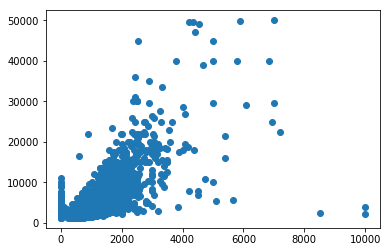

In [5]:
plt.scatter(train_df['size_sqft'],train_df['rent'])

In [6]:
#Had to remove features with strings as the type i.e. 'addr_city', 'neighborhood', 'borough'
#Might have to try turning them into numbers to find out how important they are
features = ['bedrooms', 'bathrooms', 'size_sqft', 'addr_zip', 'bin', 'bbl',
                    'floor_count', 'has_doorman', 'has_elevator',
                    'has_fireplace', 'has_dishwasher','is_furnished', 'has_gym', 'allows_pets',
                    'has_washer_dryer', 'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool',
                    'has_garden', 'has_childrens_playroom', 'no_fee', 'rent']

#Most important features (comment it out to test every feature)
# features = ['size_sqft', 'bbl', 'bathrooms', 'bedrooms', 'rent']

print('Train NaNs:', train_df[features].isna().sum(), sep='\n')
print('\n')
print('Test NaNs:', test_df[features].isna().sum(), sep='\n')

train_features = train_df[features].dropna()
train_target = train_features['rent']
train_features = train_features.drop(labels='rent', axis=1)
test_features = test_df[features]
test_target = test_features['rent']
test_features = test_features.drop(labels='rent', axis=1)

Train NaNs:
bedrooms                  0
bathrooms                 0
size_sqft                 0
addr_zip                  0
bin                       1
bbl                       0
floor_count               0
has_doorman               0
has_elevator              0
has_fireplace             0
has_dishwasher            0
is_furnished              0
has_gym                   0
allows_pets               0
has_washer_dryer          0
has_garage                0
has_roofdeck              0
has_concierge             0
has_pool                  0
has_garden                0
has_childrens_playroom    0
no_fee                    0
rent                      0
dtype: int64


Test NaNs:
bedrooms                  0
bathrooms                 0
size_sqft                 0
addr_zip                  0
bin                       0
bbl                       0
floor_count               0
has_doorman               0
has_elevator              0
has_fireplace             0
has_dishwasher            0
is_furnish

In [7]:
# Checking if there are any missing values for the features in the test2.csv set
print('test2.csv NaNs:', submit1_df[features].isna().sum(), sep='\n')

test2.csv NaNs:
bedrooms                     0
bathrooms                    0
size_sqft                    0
addr_zip                     0
bin                          0
bbl                          0
floor_count                  0
has_doorman                  0
has_elevator                 0
has_fireplace                0
has_dishwasher               0
is_furnished                 0
has_gym                      0
allows_pets                  0
has_washer_dryer             0
has_garage                   0
has_roofdeck                 0
has_concierge                0
has_pool                     0
has_garden                   0
has_childrens_playroom       0
no_fee                       0
rent                      2000
dtype: int64


In [8]:
# fits estimator to training set and predicts on test1.csv features
# prints out MSE of predictions against test1.csv
# also calculates and prints std dev & mean of 5-fold CV  on training set
def getResults(estimator):
    estimator.fit(train_features, train_target)
    test_pred = estimator.predict(test_features)
    cv_results = cross_val_score(estimator, train_features, train_target, cv=5, scoring='neg_mean_squared_error')
    print('Mean Squared Error: ', mean_squared_error(test_target, test_pred))
    print("CV Results (Std Dev): ", np.std(cv_results))
    print("CV Results (Mean): ", np.mean(cv_results))


#To get the feature importances for linear regression scale the features and then use .coef_
#importances for lr are in magnitude while others are in percentage
#I haven't scaled the features so this code doesn't really tell you much
def getImportances(estimator):
    importances = estimator.coef_ if isinstance(estimator, LinearRegression) else estimator.feature_importances_*100
    print('\nFeature Importances')
    for i in range(len(importances)):
        print(features[i], importances[i])

In [9]:
lr = LinearRegression()
dt = DecisionTreeRegressor()
gb = GradientBoostingRegressor()
rf = RandomForestRegressor()

names = ['\nLinear Regression', '\nDecision Tree Regressor', '\nGradient Boosting Regressor', '\nRandom Forest Regressor']
estimators = [lr, dt, gb, rf]

for i in range(len(names)):
    print(names[i])
    getResults(estimators[i])
    getImportances(estimators[i])


Linear Regression
Mean Squared Error:  3300873.6270710756
CV Results (Std Dev):  694184.5850992514
CV Results (Mean):  -3200244.8740285933

Feature Importances
bedrooms 236.94645999212054
bathrooms 1354.5305714598742
size_sqft 2.3601363027096585
addr_zip -0.5718846776226555
bin 0.00011545187920058963
bbl -4.346491332399819e-07
floor_count 1.133421925374219
has_doorman 156.22400451384567
has_elevator 288.82556752020724
has_fireplace 610.1505509455275
has_dishwasher -165.19816533150683
is_furnished 850.5115913268595
has_gym 336.59479147118753
allows_pets 177.11935776800644
has_washer_dryer 398.9977464466929
has_garage -160.96124995000596
has_roofdeck 195.1783511269286
has_concierge 274.9659067086464
has_pool 203.29186404660302
has_garden 36.417393424920114
has_childrens_playroom 83.63483907015184
no_fee -266.395500943024

Decision Tree Regressor
Mean Squared Error:  2546643.0144340275
CV Results (Std Dev):  400685.1885729117
CV Results (Mean):  -2588463.376807914

Feature Importances
be

GradientBoostingRegressor or RandomForestRegressor seems to give us the best score so far, further testing with hyperparameters is needed

In [10]:
def testHyperparameter(param_grid):
    results = {}
    hp_name = list(param_grid.keys())[0]
    hp_values = list(param_grid.values())[0]
    
    # Create decision tree model and tune hyperparameter using GridSearchCV
    decision_tree = DecisionTreeRegressor()
    dt_cv = GridSearchCV(dt, param_grid, cv=5)
    dt_cv.fit(train_features, train_target)
    results['best_param'] = dt_cv.best_params_
    results['best_score'] = dt_cv.best_score_
    
    # Grab mean test/train score of 5 splits
    mean_test = dt_cv.cv_results_['mean_test_score']
    mean_train = dt_cv.cv_results_['mean_train_score']

    # Plot mean test/train AUC score against hyperparameter values
    line1, = plt.plot(hp_values, mean_test, 'b', label='Test AUC')
    line2, = plt.plot(hp_values, mean_train, 'r', label='Train AUC')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC Score')
    plt.xlabel(hp_name)
    plt.show()
    
    print(results)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


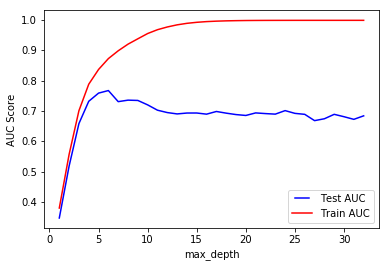

{'best_param': {'max_depth': 6}, 'best_score': 0.7668858504412275}


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


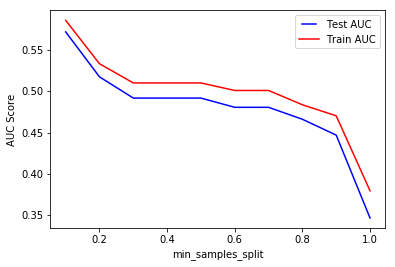

{'best_param': {'min_samples_split': 0.1}, 'best_score': 0.5718101018111018}


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


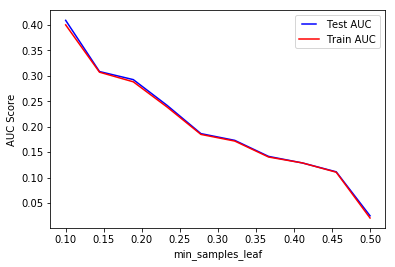

{'best_param': {'min_samples_leaf': 0.1}, 'best_score': 0.40917071386915227}


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


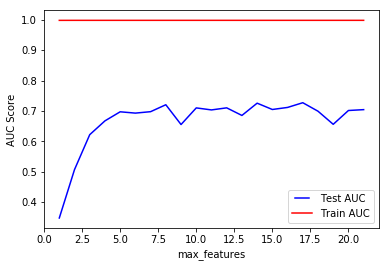

{'best_param': {'max_features': 17}, 'best_score': 0.7272033765347513}


In [11]:
# Tuning individual hyperparameters for decision tree regressor 
param_grids = []

# Hyperparameter 1: max_depth -> indicates depth of tree; 
# Testing range of 1 to 32
max_depth_values = np.arange(1, 33)
param_grids.append({'max_depth': max_depth_values})

# Hyperparameter 2: min_samples_split <- minimum number of samples required to split a node
# Testing range from 10% to 100%
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
param_grids.append({'min_samples_split': min_samples_split})

# Hyperparameter 3: min_samples_leaf <- minimum number of samples required at each leaf node
# Testing range from 10% to 50%
min_samples_leaf = np.linspace(0.1, 0.5, 10, endpoint=True)
param_grids.append({'min_samples_leaf': min_samples_leaf})

# Hyperparameter 4: max_features <- max number of features to test
# Testing range from 1 to 1 less than the number of features in the df
max_features = list(range(1,train_features.shape[1]))
param_grids.append({'max_features': max_features})

for hyperparameter in param_grids:
    testHyperparameter(hyperparameter)


In [12]:
# Testing all 4 hyperparameters together to find the best combination
param_grid = {
              "min_samples_split": [10, 20, 40, 80, 160],
              "max_depth": [2, 6, 8, 10, 15, 20, 30, 40, 50],
              "min_samples_leaf": [20, 40, 100, 200, 400],
              "max_leaf_nodes": [5, 20, 100, 200, 500]
              }

dtr = DecisionTreeRegressor()
dtr_cv = RandomizedSearchCV(dtr, param_grid, cv=5, n_iter = 1000, n_jobs=-1)
dtr_cv.fit(train_features, train_target)
print(dtr_cv.best_params_)
print(dtr_cv.best_score_)
print(dtr_cv.best_estimator_)

{'min_samples_split': 10, 'min_samples_leaf': 20, 'max_leaf_nodes': 500, 'max_depth': 30}
0.7753560639533302
DecisionTreeRegressor(criterion='mse', max_depth=30, max_features=None,
           max_leaf_nodes=500, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=20,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')


In [13]:
# Results of predicting rent on test set using optimized decision tree
optimized_dt = dtr_cv.best_estimator_
test_pred = optimized_dt.predict(test_features)
cv_results = cross_val_score(optimized_dt, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('DecisionTreeRegressor')
print('Mean Squared Error: ', mean_squared_error(test_target, test_pred))
print("CV Results: ", cv_results)
print("Mean CV Results: ", np.mean(cv_results))

DecisionTreeRegressor
Mean Squared Error:  2552114.5957740224
CV Results:  [-2063892.14936581 -1920682.9956268  -2371413.32928026 -1515768.79470367
 -1452451.22440223]
Mean CV Results:  -1864841.698675755


In [14]:
rf = RandomForestRegressor(random_state = 42)

# not too important to care about. just wanted to see parameters inside
from pprint import pprint

pprint(rf.get_params())

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [15]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 16, 32]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 8, 16, 32],
 'min_samples_split': [2, 5, 10, 20, 50],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [16]:
#Random Search Training
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50,
                              cv = 5, random_state = 42, n_jobs = -1)

rf_random.fit(train_features, train_target)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 50], 'min_samples_leaf': [1, 2, 4, 8, 16, 32], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [17]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

Now testing optimized random forest

In [18]:
optimized_rf =  rf_random.best_estimator_
test_pred = optimized_rf.predict(test_features)
cv_results = cross_val_score(optimized_rf, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('Mean Squared Error: ', mean_squared_error(test_target, test_pred))
print("CV Results: ", cv_results)
print("Mean CV Results: ", np.mean(cv_results))

#Mean Squared Error slightly decreases.

Mean Squared Error:  1676593.1779592675
CV Results:  [-1611203.82338662 -1007550.27018759 -1312625.83638499 -1132119.72463052
  -677514.56832008]
Mean CV Results:  -1148202.8445819612


In [24]:
test_pred

array([ 2608.0725    ,  2227.7795    ,  2910.6055    , ...,
       15812.801     ,  3591.9205    ,  2828.17833333])

In [19]:
test_rental_id = test_df.iloc[:,0]
print(test_rental_id)

rental_id
7499437        #1B
7477903        #C4
7481023    #GARDEN
7479547        #2C
7518814         #9
7524679     #APT3F
7441537        NaN
7523245       #33C
7516717        #18
7523536        #C1
7519651    3-FLOOR
7441630         #7
7522765        #2L
7452826        #2K
7500427         #2
7466614        #15
7464721       #417
7446442      #104B
7471321         #A
7448446        #4A
7515463        #2B
7464994         #2
7430950       #11E
7443730    #PARLOR
7472581       #44B
7497742        #2B
7470814        #2L
7444810        #7O
7508281         #1
7434526        #8E
            ...   
7443601       #204
7525285       #C32
7433635       #35E
7516393        #10
7486066       #PHD
7521223        #3E
7441411         #2
7525294       #C47
7430374       #E13
7437217       #10D
7435615        #4F
7430287        #2D
7493593        #A2
7469836        #8A
7464919        #4B
7516267        #4C
7445845        #5N
7429897        #3A
7524892        #1E
7438600         #B
7437901         #2
75

In [20]:
# checking for any missing values in test2.csv 
submit1_features = submit1_df[features].drop(labels='rent', axis=1)
submit1_features.isnull().sum().sum()

0

In [21]:
# Create submission file for test2.csv
submit1_df['predictions'] = optimized_rf.predict(submit1_features)
submit1_df['predictions'].to_csv('test2_submission.csv', header=True)

In [22]:
submit1_df['predictions'].describe()

count     2000.000000
mean      3535.277433
std       2445.450909
min       1357.160000
25%       2347.910813
50%       2930.107167
75%       3823.323500
max      29058.908000
Name: predictions, dtype: float64

In [25]:
# Checking feature importance for optimized random forest
getImportances(optimized_rf)


Feature Importances
bedrooms 7.5710210248901815
bathrooms 19.300023928080186
size_sqft 33.143776263291585
addr_zip 6.009107365779885
bin 5.895649166374871
bbl 9.441747888250442
floor_count 3.5615029280822754
has_doorman 1.2283878127069718
has_elevator 1.1297007031303772
has_fireplace 0.5332332057512971
has_dishwasher 1.1341438652564306
is_furnished 0.799111845161416
has_gym 0.999017805626529
allows_pets 0.5878155197230627
has_washer_dryer 3.6093069109792513
has_garage 0.2755510702150737
has_roofdeck 0.7791395342728563
has_concierge 0.9621217653033062
has_pool 0.5130454009216253
has_garden 0.8003512382148087
has_childrens_playroom 0.4264600136669603
no_fee 1.2997847443206039
